# Watson OpenScale SHAP Kernel metric for binary classification model

The notebook will train German Credit Risk model, generate local and global explanations using SHAP kernel explainer and provide insights into model behaviour.

### Contents
- [Setup](#Setup)
- [Model building and evaluation](#model)
- [OpenScale configuration](#openscale)
- [Compute SHAP explanations](#shap)
- [Visualize the explanations](#visualize)

**Note:** This notebook requires service credentials of Watson OpenScale.

## Setup

### Package Installation

In [ ]:
!pip install --upgrade ibm-watson-openscale --no-cache | tail -n 1
!pip install --upgrade ibm-metrics-plugin --no-cache | tail -n 1
!pip install matplotlib==3.2.2

**Action: Restart the kernel!**

### Configure Credentials

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Provide your IBM Watson OpenScale credentials in the following cell:

In [1]:
WOS_CREDENTIALS = {
    "url": "<cluster url>",
    "username": "",
    "password": "",
    "instance_id": "<service instance id>"
}

## Model building and evaluation <a name="model"></a>

In this section you will learn how to train Scikit-learn model, run prediction and evaluate its output.

### Load the training data from github

In [ ]:
!rm german_credit_data_training.csv
!wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/credit_risk/german_credit_data_biased_training.csv -O german_credit_data_training.csv

In [3]:
import numpy as np
import pandas as pd

training_data_file_name = "german_credit_data_training.csv"
data_df = pd.read_csv(training_data_file_name)

### Explore data

In [4]:
data_df.head()

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
1,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,none,...,savings_insurance,37,stores,own,2,skilled,1,none,yes,No Risk
2,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,none,...,real_estate,28,none,own,2,skilled,1,yes,no,No Risk
3,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
4,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,none,...,unknown,57,none,own,2,skilled,1,none,yes,Risk


In [5]:
print("Columns: ", list(data_df.columns))
print("Number of columns: ", len(data_df.columns))

Columns:  ['CheckingStatus', 'LoanDuration', 'CreditHistory', 'LoanPurpose', 'LoanAmount', 'ExistingSavings', 'EmploymentDuration', 'InstallmentPercent', 'Sex', 'OthersOnLoan', 'CurrentResidenceDuration', 'OwnsProperty', 'Age', 'InstallmentPlans', 'Housing', 'ExistingCreditsCount', 'Job', 'Dependents', 'Telephone', 'ForeignWorker', 'Risk']
Number of columns:  21


As you can see, the data contains twenty one fields. Risk field is the one you would like to predict.

In [6]:
print("Number of records: ", data_df.Risk.count())

Number of records:  5000


In [7]:
target_count = data_df.groupby("Risk")["Risk"].count()
target_count

Risk
No Risk    3330
Risk       1670
Name: Risk, dtype: int64

### Create a model

In this section you will learn how to:

- Prepare data for training a model
- Create machine learning pipeline
- Train a model
- Evaluate a model

#### Import required libraries

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

#### Splitting the data into train and test

In [9]:
features=list(data_df.columns)[:-1]
X = data_df[features]
y = data_df["Risk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#### Preparing the pipeline

In this step you will create tranformers for the numeric and categorical features, encode target column labels into numeric values. You can use inverse_transform to decode numeric predictions into labels.

A pipeline is created using the column transformer and the classifier object 

In [10]:
categorical_features_indexes = [i for i,x in enumerate([str(i) for i in X.dtypes]) if x == "object"]
categorical_features=[features[i] for i in categorical_features_indexes]
numeric_features=[f for f in features if f not in categorical_features]

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
ct = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),("cat", categorical_transformer, categorical_features)])
le = LabelEncoder()

y_train_e = le.fit_transform(y_train)
y_test_e = le.transform(y_test)

In [11]:
model=RandomForestClassifier(n_estimators=100, random_state=1)
pipeline = Pipeline([("ct", ct), ("clf", model)])

#### Train a model

In [12]:
pipeline = pipeline.fit(X_train, y_train_e)

#### Evaluate the model

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_e, pipeline.predict(X_test))

0.807

## Openscale Configuration <a name="openscale"></a>

Import the necessary libraries and set up OpenScale Python client.

In [ ]:
from ibm_watson_openscale import APIClient as OpenScaleAPIClient
from ibm_cloud_sdk_core.authenticators import CloudPakForDataAuthenticator

authenticator = CloudPakForDataAuthenticator(
    url=WOS_CREDENTIALS["url"],
    username=WOS_CREDENTIALS["username"],
    password=WOS_CREDENTIALS["password"],
    disable_ssl_verification=True
)

client = OpenScaleAPIClient(
    service_url=WOS_CREDENTIALS["url"],
    service_instance_id=WOS_CREDENTIALS["instance_id"],
    authenticator=authenticator
)

client.version

## Compute SHAP explanations <a name="shap"></a>

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. See [paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) for technical details of the algorithm.

The Shapley value is the average marginal contribution of a feature value across all possible feature coalitions.

SHAP assigns each feature an importance value for a particular prediction which is called SHAP value. The SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained.

### Prepare input to compute SHAP explanations

#### Create spark session

In [15]:
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.appName("TestMetrics").getOrCreate()

22/03/29 23:57:20 WARN Utils: Your hostname, Prataps-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.197 instead (on interface en0)
22/03/29 23:57:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/29 23:57:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Create configuration for computing the SHAP metric

Set the below properties in the configuration

- **problem_type** : The model problem type. Possible values are 'binary', 'multiclass', 'regression'
- **input_data_type**: The input data type. Supported value is 'structured'
- **feature_columns**: The list of feature columns
- **categorical_columns**: The list of categorical columns
- **explainability**: The expainability metrics configuration

Optional parameters for shap kernel metric
- **explanation_types**: The list of explanation types to be generated. Supported values are **global**, **local**. By default both the local and global explanations are generated. Default value is **["global", "local"]**
- **aggregation_methods**: The list of aggregation methods used to combine the shap values of all the datapoints to get the global explanation. Supported values are **mean_abs**(mean of absolute shap values), **max_abs**(max od absolute shap values), **mean_sq**(mean of squares of shap values). Default value is **["mean_abs"]**
- **link**: The generalized linear model link to connect the feature importance values to the model output. Supported values are **identity**, **logit**. Default value is **identity**. For a model with probability output, the logit link value makes the feature importance values have log-odds units which are more naturally additive compared to probability. In the current example, logit is not used as the model can produce infinite log-odds values.

In [16]:
from ibm_metrics_plugin.common.utils.constants import ExplainabilityMetricType, ProblemType, InputDataType, MetricGroupType
from ibm_metrics_plugin.metrics.explainability.entity.constants import ShapAlgorithm, ShapAggregationMethod, ExplanationType

configuration={
    "configuration": {
        "problem_type": ProblemType.BINARY.value,
        "input_data_type": InputDataType.STRUCTURED.value,
        "feature_columns": features,
        "categorical_columns": categorical_features,
        MetricGroupType.EXPLAINABILITY.value : {
            "metrics_configuration": {
                ExplainabilityMetricType.SHAP.value : {
                    "algorithm": ShapAlgorithm.KERNEL.value,
                    "aggregation_methods": [ShapAggregationMethod.MEAN_ABS.value, ShapAggregationMethod.MAX_ABS.value]
                    # "explanation_types": [ExplanationType.GLOBAL.value]
                    # "link": "logit"
                }
            }
        }
    }
}

#### Define the scoring function

The scoring function will be used to score against the model and get the prediction and probability values. The scoring function should take a pandas dataframe as input and return prediction and probability values.

Note: For classification model, returning the prediction values is optional. For regression model probability values can be returned as None.

In [17]:
def scoring_fn(data):
    return None, pipeline.predict_proba(data)

#### Define the background data

The background dataset is used for integrating out features. To determine the impact of a feature, that feature is set to "missing" and the change in the model output is observed. Since most models aren't designed to handle arbitrary missing data at test time, SHAP simulates "missing" by replacing the feature with the values it takes in the background dataset. So if the background dataset is a simple sample of all zeros, then SHAP would approximate a feature being missing by setting it to zero.

The background data is used to compute the baseline(average) model output.
For small problems this background dataset can be the whole training set, but for larger problems consider using a single reference value or summarize the dataset.
The background data could also be a subset of data against which we want to compare the model prediction.
Using large background data samples would make the explanation generation slower.

For the above dataset we are summarizing the dataset by taking the median values for numeric features and frequent occuring values(mode) for categorical features.

In [18]:
mod = X_train.mode()
med = X_train.median()
for f in numeric_features:
    mod.at[0, f] = med[f]
background_data = mod

/var/folders/40/9kzbn1sd42s5j4fwmfzxx2540000gn/T/ipykernel_22323/2215763446.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  med = X_train.median()


### Compute explanations

Compute the explanations for the test data. The test data could be a spark dataframe or pandas dataframe. Here we use a pandas dataframe.

In [19]:
metrics_result = client.ai_metrics.compute_metrics(spark=spark, 
                                            configuration=configuration, 
                                            data_frame=X_test, 
                                            scoring_fn=scoring_fn, 
                                            background_data=background_data)

/Users/pratap/Documents/MyData/Github/metric-plugins/venv38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
{"appname": "metrics-plugin", "loglevel": "INFO", "timestamp": "Tue Mar 29 23:57:51 2022", "message_details": "Discovered groups : [<ibm_metrics_plugin.metrics.explainability.impl.explainability_metrics_evaluator.ExplainabilityMetricsEvaluator object at 0x7febb7900f10>]"}
{"appname": "metrics-plugin", "loglevel": "INFO", "timestamp": "Tue Mar 29 23:57:51 2022", "message_details": "Evaluating explainability metrics.."}
{"appname": "metrics-plugin", "loglevel": "INFO", "timestamp": "Tue Mar 29 23:57:51 2022", "message_details": "Evaluating Explainer: 'shap'..."}
{"appname": "metrics-plugin", "loglevel": "INFO", "timestamp": "Tue Mar 29 23:57:51 2022", "message_details": "Evaluating shap metric"}


## Visualize the explanations <a name="visualize"></a>

### Convert metrics result to shap explanations object

Convert the metrics result dict to shap explanations object, which can be used for plotting the explanations

In [20]:
shap_explanations=client.ai_metrics.transform_result(metrics_result=metrics_result, 
                                                     metric_group_type=MetricGroupType.EXPLAINABILITY.value, 
                                                     metric_type=ExplainabilityMetricType.SHAP.value)

### Visualize the local explanation

Plot the local explanation for the first data point and for class 0(No Risk).

In [21]:
shap=shap_explanations.get("shap")
shap.initjs()

Get the local explanations for class 0 (No Risk)

In [22]:
local_explanations = shap_explanations.get("local")
if local_explanations:
    local_explanations = local_explanations[0]

**Visualize the explanation for the first datapoint prediction**

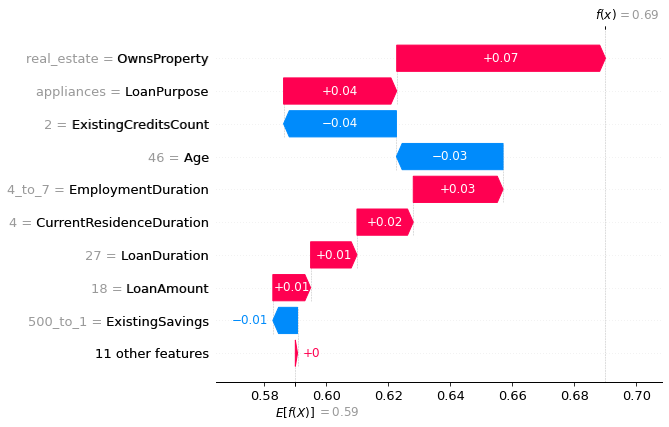

In [23]:
if local_explanations:
    shap.plots.waterfall(local_explanations[0])

The above explanation shows the features contributing to the model output from the base value (the average model output over the background data passed) to the model output of this data point. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

Another way to visualize the same explanation is to use a force plot.

In [24]:
if local_explanations:
    shap.plots.force(local_explanations[0])

### Visualize the summary of explanations

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). This reveals for example that a high LoanDuration lowers the probability of No Risk class (In other words it means it increases Risk).

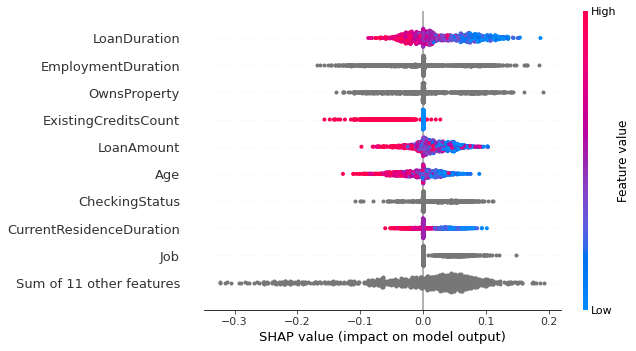

In [25]:
if local_explanations:
    shap.plots.beeswarm(local_explanations)

The generated global explanations(mean_abs or max_abs or mean_sq) could be plotted as a bar plot to understand the overall importance of features.

In the below plot the mean absolute shap values are plotted.

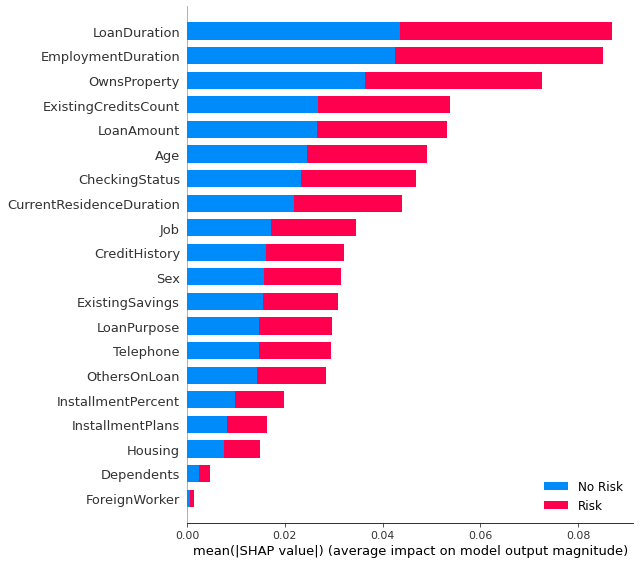

In [26]:
global_explanations = shap_explanations.get("global")
if global_explanations:
    global_explanation = global_explanations.get("mean_abs")
    shap.summary_plot(global_explanation, class_names=["No Risk", "Risk"])

In the below plot the max absolute shap values are plotted.

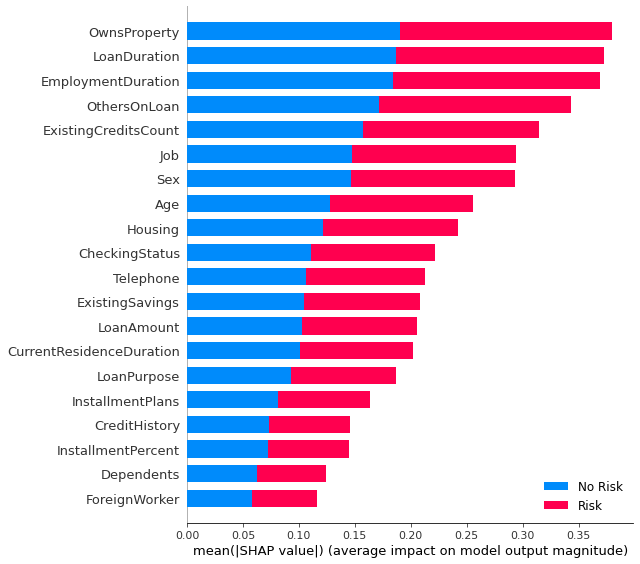

In [27]:
if global_explanations:
    global_explanation = global_explanations.get("max_abs")
    shap.summary_plot(global_explanation, class_names=["No Risk", "Risk"])

To understand how a single feature effects the output of the model, the SHAP value of that feature and the value of the feature for all the datapoints could be plotted. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in output for No Risk class as LoanDuration changes. Vertical dispersion at a single value of LoanDuration represents interaction effects with other features. When all the SHAP values are passed, the feature having the higher interaction would be picked up automatically if not specified.

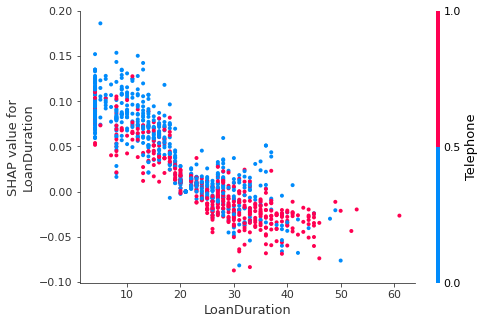

In [28]:
if local_explanations:
    shap.dependence_plot("LoanDuration", local_explanations.values, local_explanations.data, feature_names=local_explanations.feature_names)

**Authors**

Developed by Pratap Kishore Varma V